# Motor de redes neuronales

En el siguiente notebook explicamos la funcionalidad que se llevado a cabo para hacer el motor de redes neuronales.

En primer lugar, se crea la instancia llamando a los modulos pertinentes que contienen las implementaciones. Hemos intentado hacer una buena separación en módulos para mejorar, no solo el orden, sino también la claridad del código a la hora de usarlo sin necesidad de estar poniendo muchos comentarios, ya que eso es una mala práctica a la larga.

In [1]:
import numpy as np

In [2]:
from src.neural_network.neural_network import train, predict, create_nn, test_nn
from src.neural_network.utils.draw_nn import draw_nn
from src.neural_network.layers.activation.functions import Relu, Tanh, LeakyRelu
from src.neural_network.utils.graphics.regression import learning_curve, dispersion_graph
from src.neural_network.optimizers.sgd import SGD
from src.neural_network.optimizers.adam import Adam
from src.neural_network.optimizers.adagrad import Adagrad
from src.neural_network.losses.cross_entropy import CrossEntropyLoss
from src.neural_network.losses.mse import MSELoss

In [3]:
optimizers = [
    Adagrad(learning_rate=0.07),
    Adagrad(learning_rate=0.07),
    Adagrad(learning_rate=0.07)
]

activations = [LeakyRelu(alpha=0.017), LeakyRelu(alpha=0.017), LeakyRelu(alpha=0.017)]

nn = create_nn([10, 8, 8, 3], activation_function=activations, optimizers=optimizers)

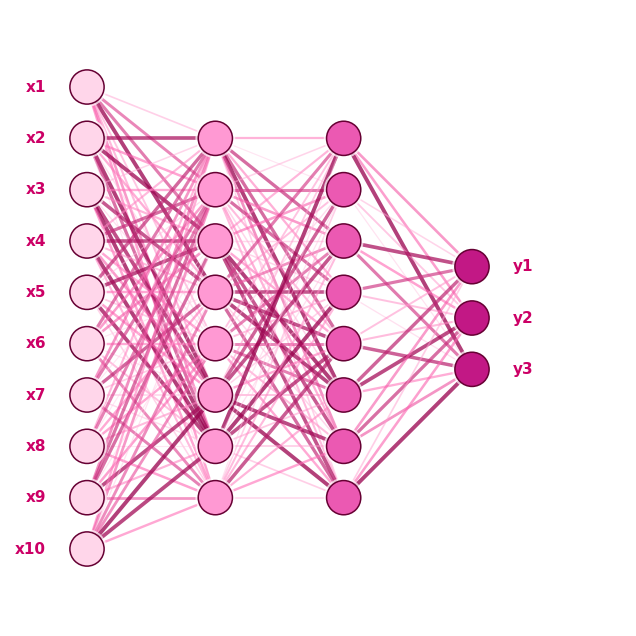

In [4]:
draw_nn(nn)


# Entrenamiento

La función **train** devuelve un historial del valor de pérdida durante el entrenamiento para poder hacer gráficas como las que se verán en las siguientes celdas.


Como parámetros necesita:
- La Red Neuronal
- La función de pérdida
- La derivada de la función de pérdida
- Los conjuntos de datos X, y
- Opcionalmente: Número de epochs, learning_rate y optimizador.


Es preciso que las variables X, y sean pasadas como arrays de numpy y tenga el siguiente shape:

- X.shape = (n_samples, n_features, 1)
- Y.shape = (n_samples, 1)

Esto se debe a que la red espera como datos de entrada un vector columna.

(Para simplicidad de la explicación vamos un conjunto de 
datos muy reducido tanto para entrenamiento como prueba, los experimentos reales se encuentran en el notebook testing de la carpeta tests)

In [5]:
X_train = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
y_train = np.array([[0], [1], [1], [1], [0], [0], [0]])

X_train = X_train.reshape((7, 3, 1))
y_train = y_train.reshape((7, 1))

optimizers = [Adam(learning_rate=0.01),
              Adam(learning_rate=0.01)]

activations = [Tanh(), Tanh()]

nn = create_nn([3, 2, 1], activation_function=activations, optimizers=optimizers)

loss = CrossEntropyLoss()

train_loss = train(nn, loss, X_train, y_train, epochs=700)

# Evaluación (Test)
Nos preguntamos: ¿La red realmente aprendió algo útil, o solo imitó los datos del entrenamiento?

Una vez entrenada la red, es necesario evaluar su rendimiento utilizando un conjunto de muestras que no haya visto anteriormente. Esto nos permite comprobar si el modelo ha aprendido patrones generales y no simplemente memorizado los datos de entrenamiento (lo que se conoce como overfitting).

Para ello, basta con ejecutar una celda similar a la siguiente:

```bash
y_pred = predict(nn, X_test)
```

La variable y_pred contendrá las predicciones generadas por la red para cada una de las entradas del conjunto de prueba (X_test).
Comparando estas predicciones con los valores reales (y_test), podremos medir la precisión del modelo o analizar visualmente qué tan bien se aproxima a la solución esperada.

In [6]:
_, _ = test_nn(nn, X_train, y_train)

Accuracy: 100.0%


In [7]:
y_pred = []
for X, y in zip(X_train, y_train):
    output = predict(nn, X)
    y_pred.append(output)
    print(f'Pred: {output[0]}, Actual: {y}')

Pred: [0.00117854], Actual: [0]
Pred: [0.24775398], Actual: [1]
Pred: [0.9643848], Actual: [1]
Pred: [0.96618471], Actual: [1]
Pred: [0.24806009], Actual: [0]
Pred: [0.24947445], Actual: [0]
Pred: [0.24806021], Actual: [0]


A continuación se muestra la evolución de la pérdida durante el entrenamiento, lo cual nos permite observar cómo la red va ajustando sus parámetros para reducir el error. Una curva de pérdida que desciende de forma estable suele indicar que el modelo está aprendiendo correctamente.

Además, se presenta un gráfico de dispersión que compara los valores predichos por la red frente a los valores reales.
Si la red ha aprendido bien, los puntos deberían alinearse aproximadamente sobre la diagonal, lo que significa que las predicciones se aproximan a los valores esperados.

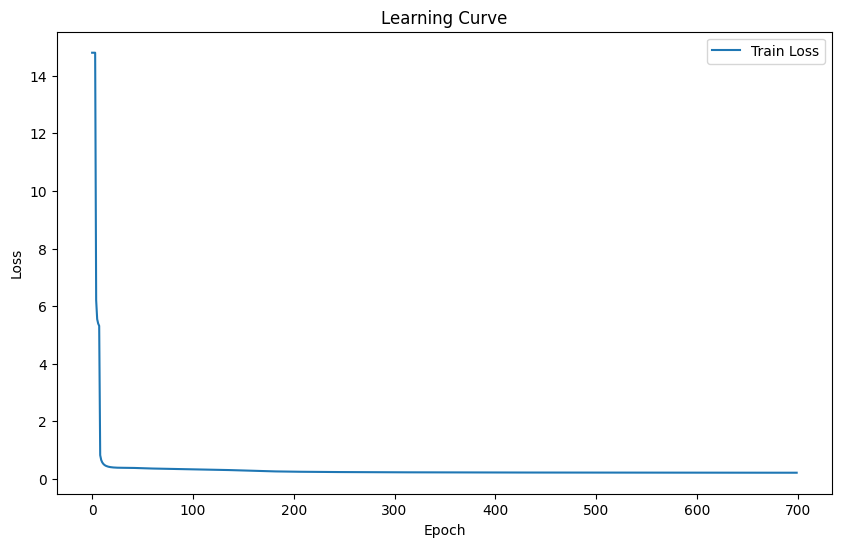

In [8]:
learning_curve(train_loss)



# ¿Qué nos dice esta gráfica?

La línea muestra cómo la pérdida va bajando durante el entrenamiento.
Al principio el error es alto, pero disminuye rápido, lo que significa que la red está aprendiendo.

Luego la curva se aplana y se mantiene casi constante, indicando que el modelo ya ha aprendido todo lo importante y ha llegado a un punto estable.

En resumen:
La red ha aprendido bien y hace buenas predicciones sobre los datos de entrenamiento.